Unsupervised representational learning using WGAN

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os 
from tqdm import tqdm
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder

In [50]:
class Discriminator(nn.Module):
    def __init__(self,channel_img,features_d):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channel_img,features_d,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d,features_d*2,4,2,1),
            self._block(features_d*2,features_d*4,4,2,1),
            self._block(features_d*4,features_d*8,4,2,1),
            nn.Conv2d(features_d*8,1,4,2,0),
        )
            
    def _block(self,in_channels,out_channels,kernel_size,stride,padding,bias=False):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self,x):
        return self.disc(x)

In [51]:
class Generator(nn.Module):
    def  __init__(self,channels_noise,img_dim,features_g):
        super(Generator,self).__init__()
        self.gen = nn.Sequential(
            self._block(channels_noise,features_g*16,4,1,0),
            self._block(features_g*16,features_g*8,4,2,1),
            self._block(features_g*8,features_g*4,4,2,1),
            self._block(features_g*4,features_g*2,4,2,1),
            nn.ConvTranspose2d(features_g*2,img_dim,4,2,1),
            nn.Tanh(),
        )
    
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
#             nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
    def forward(self,x):
        return self.gen(x)

In [52]:
# initalizing weights of the model with mean 0 and std dev 1
def initialize_weights(model):
    for m in model.modules():
#         print(m)
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02)

In [53]:
def test():
    N, in_channels, H, W = 8,3,64,64
    noise =100
    X = torch.randn((N,in_channels,H,W))
    disc = Discriminator(in_channels,8)
    initialize_weights(disc)
    assert disc(X).shape == (N,1,1,1), "Disc Failed"
    gen = Generator(noise,in_channels,8)
    z = torch.randn((N,noise,1,1))
    assert gen(z).shape == (N,in_channels,H,W), "gen Failed"
    print("success")

In [54]:
test()

success


In [55]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [56]:
#hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 64
features_gen = 64
features_disc = 64
batch_size = 64
z_dim = 100
epochs = 8
channels = 3
lr = 5e-5
critic_iter = 5
weight_clip = 0.01

In [57]:
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size), 
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(channels)], [0.5 for _ in range(channels)]
        ),
    ]
)

In [58]:
# dataset = datasets.MNIST(
#     root="dataset/", train=True, transform=transform, download=True
# )

dataset = ImageFolder(r"C:\Users\dhruv\Untitled Folder\Fake Face Image Generator\celeb_dataset", transform=transform)

dataloader = DataLoader(dataset, batch_size, shuffle=True)
gen = Generator(noise_dim, channels, features_gen).to(device)
critic = Discriminator(channels, features_disc).to(device)
initialize_weights(gen)
initialize_weights(critic)

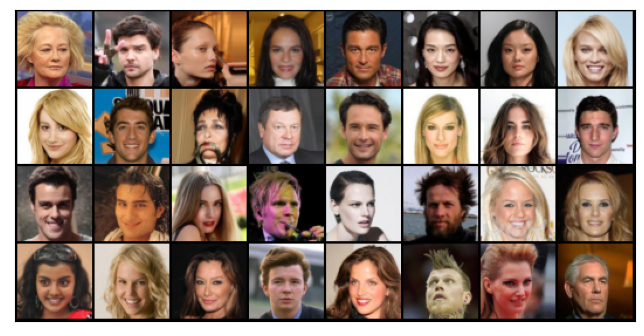

In [59]:
show_batch(dataloader)

In [60]:
opt_gen = optim.RMSprop(gen.parameters(), lr)
opt_critic = optim.RMSprop(critic.parameters(), lr)

In [61]:
# Replace 'output_directory' with your desired directory path
output_directory = 'generated_images_celeb_wgan'
os.makedirs(output_directory, exist_ok=True)

In [62]:
fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0
gen.train()
critic.train()
for epoch in range(epochs):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(tqdm(dataloader)):
        real = real.to(device)
        
        for _ in range(critic_iter):
            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = - (torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
            
            for p in critic.parameters():
                p.data.clamp_(-weight_clip,weight_clip)
            
        #Train Generator
        output = critic(fake).reshape(-1)
        loss_gen = - torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        
        # Print losses occasionally and print to tensorboard
        # Print losses occasionally and save a grid of generated fake images
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)

                # Save a grid of generated fake images
                fake_grid = vutils.make_grid(fake, normalize=True, padding=2, nrow=8)  # Adjust nrow as needed

                image_filename = os.path.join(output_directory, f'fake_images_epoch{epoch}_batch{batch_idx}.png')
                vutils.save_image(fake_grid, image_filename)

                # Display real and fake images in TensorBoard
                img_grid_real = vutils.make_grid(real[:32], normalize=True, padding=2, nrow=8)
                img_grid_fake = vutils.make_grid(fake[:32], normalize=True, padding=2, nrow=8)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1


  0%|                                                                                         | 0/3166 [00:00<?, ?it/s]

Epoch [0/8] Batch 0/3166                   Loss D: -0.0742, loss G: 0.0223


  3%|██▍                                                                          | 101/3166 [02:06<1:08:19,  1.34s/it]

Epoch [0/8] Batch 100/3166                   Loss D: -1.4615, loss G: 0.6890


  6%|████▊                                                                        | 200/3166 [04:15<1:07:23,  1.36s/it]

Epoch [0/8] Batch 200/3166                   Loss D: -1.4878, loss G: 0.7022


  9%|███████▎                                                                     | 300/3166 [06:25<1:06:02,  1.38s/it]

Epoch [0/8] Batch 300/3166                   Loss D: -1.3484, loss G: 0.6602


 13%|█████████▉                                                                     | 400/3166 [08:24<55:14,  1.20s/it]

Epoch [0/8] Batch 400/3166                   Loss D: -1.3857, loss G: 0.6766


 16%|████████████▌                                                                  | 501/3166 [10:26<55:50,  1.26s/it]

Epoch [0/8] Batch 500/3166                   Loss D: -1.4106, loss G: 0.6808


 19%|██████████████▉                                                                | 600/3166 [12:30<54:08,  1.27s/it]

Epoch [0/8] Batch 600/3166                   Loss D: -1.4047, loss G: 0.6901


 22%|█████████████████▍                                                             | 700/3166 [14:38<52:22,  1.27s/it]

Epoch [0/8] Batch 700/3166                   Loss D: -1.3864, loss G: 0.6744


 25%|███████████████████▉                                                           | 801/3166 [16:52<56:24,  1.43s/it]

Epoch [0/8] Batch 800/3166                   Loss D: -1.3493, loss G: 0.6530


 28%|██████████████████████▍                                                        | 901/3166 [18:55<48:30,  1.28s/it]

Epoch [0/8] Batch 900/3166                   Loss D: -1.3664, loss G: 0.6621


 32%|████████████████████████▋                                                     | 1001/3166 [20:56<46:40,  1.29s/it]

Epoch [0/8] Batch 1000/3166                   Loss D: -1.3487, loss G: 0.6726


 35%|███████████████████████████                                                   | 1100/3166 [22:56<41:46,  1.21s/it]

Epoch [0/8] Batch 1100/3166                   Loss D: -1.3948, loss G: 0.6768


 38%|█████████████████████████████▌                                                | 1200/3166 [24:56<38:25,  1.17s/it]

Epoch [0/8] Batch 1200/3166                   Loss D: -1.2507, loss G: 0.6662


 41%|████████████████████████████████                                              | 1301/3166 [26:57<39:46,  1.28s/it]

Epoch [0/8] Batch 1300/3166                   Loss D: -1.4742, loss G: 0.7056


 44%|██████████████████████████████████▍                                           | 1400/3166 [28:58<35:05,  1.19s/it]

Epoch [0/8] Batch 1400/3166                   Loss D: -1.3576, loss G: 0.6556


 47%|████████████████████████████████████▉                                         | 1500/3166 [30:59<34:06,  1.23s/it]

Epoch [0/8] Batch 1500/3166                   Loss D: -1.4514, loss G: 0.6967


 51%|███████████████████████████████████████▍                                      | 1601/3166 [33:02<33:06,  1.27s/it]

Epoch [0/8] Batch 1600/3166                   Loss D: -1.4802, loss G: 0.7112


 54%|█████████████████████████████████████████▉                                    | 1700/3166 [35:03<29:33,  1.21s/it]

Epoch [0/8] Batch 1700/3166                   Loss D: -1.3871, loss G: 0.6742


 57%|████████████████████████████████████████████▎                                 | 1801/3166 [37:05<29:29,  1.30s/it]

Epoch [0/8] Batch 1800/3166                   Loss D: -1.3693, loss G: 0.6685


 60%|██████████████████████████████████████████████▊                               | 1900/3166 [39:04<25:18,  1.20s/it]

Epoch [0/8] Batch 1900/3166                   Loss D: -1.3603, loss G: 0.6532


 63%|█████████████████████████████████████████████████▎                            | 2000/3166 [41:05<23:06,  1.19s/it]

Epoch [0/8] Batch 2000/3166                   Loss D: -1.3793, loss G: 0.6675


 66%|███████████████████████████████████████████████████▋                          | 2100/3166 [43:03<20:15,  1.14s/it]

Epoch [0/8] Batch 2100/3166                   Loss D: -1.4858, loss G: 0.7127


 69%|██████████████████████████████████████████████████████▏                       | 2200/3166 [44:56<17:40,  1.10s/it]

Epoch [0/8] Batch 2200/3166                   Loss D: -1.4336, loss G: 0.6868


 73%|████████████████████████████████████████████████████████▋                     | 2300/3166 [46:49<16:30,  1.14s/it]

Epoch [0/8] Batch 2300/3166                   Loss D: -1.3332, loss G: 0.6609


 76%|███████████████████████████████████████████████████████████▏                  | 2401/3166 [48:44<15:10,  1.19s/it]

Epoch [0/8] Batch 2400/3166                   Loss D: -1.4197, loss G: 0.6841


 79%|█████████████████████████████████████████████████████████████▌                | 2500/3166 [50:37<12:51,  1.16s/it]

Epoch [0/8] Batch 2500/3166                   Loss D: -1.3583, loss G: 0.6584


 82%|████████████████████████████████████████████████████████████████              | 2600/3166 [52:30<10:42,  1.13s/it]

Epoch [0/8] Batch 2600/3166                   Loss D: -1.3295, loss G: 0.6539


 85%|██████████████████████████████████████████████████████████████████▌           | 2700/3166 [54:24<08:54,  1.15s/it]

Epoch [0/8] Batch 2700/3166                   Loss D: -1.0973, loss G: 0.6774


 88%|████████████████████████████████████████████████████████████████████▉         | 2800/3166 [56:18<06:46,  1.11s/it]

Epoch [0/8] Batch 2800/3166                   Loss D: -1.1293, loss G: 0.6913


 92%|███████████████████████████████████████████████████████████████████████▍      | 2900/3166 [58:12<04:52,  1.10s/it]

Epoch [0/8] Batch 2900/3166                   Loss D: -1.3141, loss G: 0.6487


 95%|████████████████████████████████████████████████████████████████████████    | 3000/3166 [1:00:05<03:08,  1.13s/it]

Epoch [0/8] Batch 3000/3166                   Loss D: -0.8455, loss G: 0.5333


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3100/3166 [1:01:59<01:13,  1.12s/it]

Epoch [0/8] Batch 3100/3166                   Loss D: -1.3629, loss G: 0.6661


  0%|                                                                                         | 0/3166 [00:00<?, ?it/s]

Epoch [1/8] Batch 0/3166                   Loss D: -1.3385, loss G: 0.6501


  3%|██▌                                                                            | 101/3166 [00:37<23:14,  2.20it/s]

Epoch [1/8] Batch 100/3166                   Loss D: -1.3425, loss G: 0.6566


  6%|████▉                                                                          | 200/3166 [01:14<18:17,  2.70it/s]

Epoch [1/8] Batch 200/3166                   Loss D: -1.4096, loss G: 0.6799


  9%|███████▍                                                                       | 300/3166 [01:52<17:43,  2.70it/s]

Epoch [1/8] Batch 300/3166                   Loss D: -1.3018, loss G: 0.6349


 13%|█████████▉                                                                     | 400/3166 [02:29<18:30,  2.49it/s]

Epoch [1/8] Batch 400/3166                   Loss D: -1.2267, loss G: 0.6311


 16%|████████████▍                                                                  | 500/3166 [03:10<17:33,  2.53it/s]

Epoch [1/8] Batch 500/3166                   Loss D: -0.9878, loss G: 0.6818


 19%|██████████████▉                                                                | 601/3166 [03:51<20:41,  2.07it/s]

Epoch [1/8] Batch 600/3166                   Loss D: -1.2652, loss G: 0.6126


 22%|█████████████████▍                                                             | 700/3166 [04:31<16:19,  2.52it/s]

Epoch [1/8] Batch 700/3166                   Loss D: -1.2946, loss G: 0.6283


 25%|███████████████████▉                                                           | 800/3166 [05:11<15:25,  2.56it/s]

Epoch [1/8] Batch 800/3166                   Loss D: -1.3013, loss G: 0.6334


 28%|██████████████████████▍                                                        | 900/3166 [05:51<15:41,  2.41it/s]

Epoch [1/8] Batch 900/3166                   Loss D: -1.2631, loss G: 0.6279


 32%|████████████████████████▋                                                     | 1000/3166 [06:31<14:22,  2.51it/s]

Epoch [1/8] Batch 1000/3166                   Loss D: -1.2552, loss G: 0.6047


 35%|███████████████████████████▏                                                  | 1101/3166 [07:12<16:17,  2.11it/s]

Epoch [1/8] Batch 1100/3166                   Loss D: -1.2069, loss G: 0.6145


 38%|█████████████████████████████▌                                                | 1200/3166 [07:53<13:29,  2.43it/s]

Epoch [1/8] Batch 1200/3166                   Loss D: -1.2052, loss G: 0.5368


 41%|████████████████████████████████                                              | 1301/3166 [08:38<16:17,  1.91it/s]

Epoch [1/8] Batch 1300/3166                   Loss D: -1.1140, loss G: 0.6241


 44%|██████████████████████████████████▍                                           | 1400/3166 [09:21<12:53,  2.28it/s]

Epoch [1/8] Batch 1400/3166                   Loss D: -1.2047, loss G: 0.5875


 47%|████████████████████████████████████▉                                         | 1500/3166 [10:06<12:20,  2.25it/s]

Epoch [1/8] Batch 1500/3166                   Loss D: -1.2389, loss G: 0.6104


 51%|███████████████████████████████████████▍                                      | 1600/3166 [10:51<11:28,  2.28it/s]

Epoch [1/8] Batch 1600/3166                   Loss D: -1.0589, loss G: 0.6399


 54%|█████████████████████████████████████████▉                                    | 1700/3166 [11:35<11:31,  2.12it/s]

Epoch [1/8] Batch 1700/3166                   Loss D: -1.2011, loss G: 0.5755


 57%|████████████████████████████████████████████▎                                 | 1800/3166 [12:20<10:48,  2.11it/s]

Epoch [1/8] Batch 1800/3166                   Loss D: -1.1705, loss G: 0.6166


 60%|██████████████████████████████████████████████▊                               | 1900/3166 [13:05<10:57,  1.92it/s]

Epoch [1/8] Batch 1900/3166                   Loss D: -1.2856, loss G: 0.6191


 63%|█████████████████████████████████████████████████▎                            | 2000/3166 [13:53<08:55,  2.18it/s]

Epoch [1/8] Batch 2000/3166                   Loss D: -1.0944, loss G: 0.6294


 66%|███████████████████████████████████████████████████▋                          | 2100/3166 [14:39<07:58,  2.23it/s]

Epoch [1/8] Batch 2100/3166                   Loss D: -0.9333, loss G: -0.0913


 69%|██████████████████████████████████████████████████████▏                       | 2200/3166 [15:26<07:45,  2.08it/s]

Epoch [1/8] Batch 2200/3166                   Loss D: -1.0260, loss G: 0.3312


 73%|████████████████████████████████████████████████████████▋                     | 2300/3166 [16:15<07:12,  2.00it/s]

Epoch [1/8] Batch 2300/3166                   Loss D: -1.1226, loss G: 0.5521


 76%|███████████████████████████████████████████████████████████▏                  | 2400/3166 [17:08<06:22,  2.00it/s]

Epoch [1/8] Batch 2400/3166                   Loss D: -0.9909, loss G: 0.6271


 79%|█████████████████████████████████████████████████████████████▌                | 2500/3166 [18:01<06:07,  1.81it/s]

Epoch [1/8] Batch 2500/3166                   Loss D: -1.2399, loss G: 0.6137


 82%|████████████████████████████████████████████████████████████████              | 2600/3166 [18:55<05:00,  1.88it/s]

Epoch [1/8] Batch 2600/3166                   Loss D: -0.8349, loss G: 0.2414


 85%|██████████████████████████████████████████████████████████████████▌           | 2700/3166 [19:49<04:11,  1.85it/s]

Epoch [1/8] Batch 2700/3166                   Loss D: -1.1050, loss G: 0.6292


 88%|████████████████████████████████████████████████████████████████████▉         | 2800/3166 [20:43<03:05,  1.98it/s]

Epoch [1/8] Batch 2800/3166                   Loss D: -1.0247, loss G: 0.3691


 92%|███████████████████████████████████████████████████████████████████████▍      | 2900/3166 [21:37<02:33,  1.73it/s]

Epoch [1/8] Batch 2900/3166                   Loss D: -1.0913, loss G: 0.5065


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3001/3166 [22:45<02:13,  1.24it/s]

Epoch [1/8] Batch 3000/3166                   Loss D: -1.0569, loss G: 0.6257


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3100/3166 [23:51<00:44,  1.49it/s]

Epoch [1/8] Batch 3100/3166                   Loss D: -0.9142, loss G: 0.6302


  0%|                                                                                         | 0/3166 [00:00<?, ?it/s]

Epoch [2/8] Batch 0/3166                   Loss D: -0.9888, loss G: 0.6119


  3%|██▍                                                                            | 100/3166 [00:37<18:51,  2.71it/s]

Epoch [2/8] Batch 100/3166                   Loss D: -1.0765, loss G: 0.5416


  6%|████▉                                                                          | 200/3166 [01:14<18:16,  2.70it/s]

Epoch [2/8] Batch 200/3166                   Loss D: -1.1277, loss G: 0.5998


 10%|███████▌                                                                       | 301/3166 [01:52<21:54,  2.18it/s]

Epoch [2/8] Batch 300/3166                   Loss D: -0.8897, loss G: 0.6240


 13%|██████████                                                                     | 401/3166 [02:30<21:08,  2.18it/s]

Epoch [2/8] Batch 400/3166                   Loss D: -1.0365, loss G: 0.4649


 16%|████████████▍                                                                  | 500/3166 [03:06<16:32,  2.69it/s]

Epoch [2/8] Batch 500/3166                   Loss D: -1.0784, loss G: 0.5496


 19%|██████████████▉                                                                | 600/3166 [03:44<15:51,  2.70it/s]

Epoch [2/8] Batch 600/3166                   Loss D: -1.0301, loss G: 0.4770


 22%|█████████████████▍                                                             | 700/3166 [04:21<15:20,  2.68it/s]

Epoch [2/8] Batch 700/3166                   Loss D: -0.9338, loss G: 0.3402


 25%|███████████████████▉                                                           | 800/3166 [04:59<14:36,  2.70it/s]

Epoch [2/8] Batch 800/3166                   Loss D: -0.9405, loss G: 0.5684


 28%|██████████████████████▍                                                        | 900/3166 [05:36<14:04,  2.68it/s]

Epoch [2/8] Batch 900/3166                   Loss D: -0.9677, loss G: 0.4487


 32%|████████████████████████▋                                                     | 1000/3166 [06:15<16:30,  2.19it/s]

Epoch [2/8] Batch 1000/3166                   Loss D: -0.9549, loss G: 0.4972


 35%|███████████████████████████▏                                                  | 1101/3166 [07:28<27:03,  1.27it/s]

Epoch [2/8] Batch 1100/3166                   Loss D: -1.0126, loss G: 0.4518


 38%|█████████████████████████████▌                                                | 1200/3166 [08:39<25:01,  1.31it/s]

Epoch [2/8] Batch 1200/3166                   Loss D: -0.9492, loss G: 0.5248


 41%|████████████████████████████████                                              | 1300/3166 [09:50<22:36,  1.38it/s]

Epoch [2/8] Batch 1300/3166                   Loss D: -0.8947, loss G: 0.5744


 44%|██████████████████████████████████▍                                           | 1400/3166 [11:02<22:26,  1.31it/s]

Epoch [2/8] Batch 1400/3166                   Loss D: -0.8619, loss G: 0.3145


 47%|████████████████████████████████████▉                                         | 1500/3166 [12:17<21:51,  1.27it/s]

Epoch [2/8] Batch 1500/3166                   Loss D: -0.9379, loss G: 0.3513


 51%|███████████████████████████████████████▍                                      | 1600/3166 [13:34<19:24,  1.35it/s]

Epoch [2/8] Batch 1600/3166                   Loss D: -0.9584, loss G: 0.4152


 54%|█████████████████████████████████████████▉                                    | 1700/3166 [14:53<19:04,  1.28it/s]

Epoch [2/8] Batch 1700/3166                   Loss D: -0.9516, loss G: 0.4086


 57%|████████████████████████████████████████████▎                                 | 1801/3166 [16:11<19:40,  1.16it/s]

Epoch [2/8] Batch 1800/3166                   Loss D: -0.9430, loss G: 0.5535


 60%|██████████████████████████████████████████████▊                               | 1900/3166 [17:25<16:18,  1.29it/s]

Epoch [2/8] Batch 1900/3166                   Loss D: -0.9507, loss G: 0.5533


 63%|█████████████████████████████████████████████████▎                            | 2000/3166 [18:41<14:41,  1.32it/s]

Epoch [2/8] Batch 2000/3166                   Loss D: -0.8874, loss G: 0.3349


 66%|███████████████████████████████████████████████████▊                          | 2101/3166 [19:59<14:54,  1.19it/s]

Epoch [2/8] Batch 2100/3166                   Loss D: -0.7719, loss G: 0.5603


 70%|██████████████████████████████████████████████████████▏                       | 2201/3166 [21:15<13:21,  1.20it/s]

Epoch [2/8] Batch 2200/3166                   Loss D: -0.8569, loss G: 0.5643


 73%|████████████████████████████████████████████████████████▋                     | 2300/3166 [22:31<11:13,  1.29it/s]

Epoch [2/8] Batch 2300/3166                   Loss D: -0.9857, loss G: 0.5251


 76%|███████████████████████████████████████████████████████████▏                  | 2400/3166 [23:47<09:49,  1.30it/s]

Epoch [2/8] Batch 2400/3166                   Loss D: -0.9267, loss G: 0.4041


 79%|█████████████████████████████████████████████████████████████▌                | 2501/3166 [25:05<09:33,  1.16it/s]

Epoch [2/8] Batch 2500/3166                   Loss D: -0.8525, loss G: 0.5515


 82%|████████████████████████████████████████████████████████████████              | 2601/3166 [26:20<07:56,  1.18it/s]

Epoch [2/8] Batch 2600/3166                   Loss D: -0.9271, loss G: 0.3672


 85%|██████████████████████████████████████████████████████████████████▌           | 2700/3166 [27:35<05:48,  1.34it/s]

Epoch [2/8] Batch 2700/3166                   Loss D: -0.7967, loss G: 0.5050


 88%|█████████████████████████████████████████████████████████████████████         | 2801/3166 [28:53<05:05,  1.19it/s]

Epoch [2/8] Batch 2800/3166                   Loss D: -0.9375, loss G: 0.5451


 92%|███████████████████████████████████████████████████████████████████████▍      | 2900/3166 [30:10<03:25,  1.29it/s]

Epoch [2/8] Batch 2900/3166                   Loss D: -0.8472, loss G: 0.3256


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3001/3166 [31:29<02:22,  1.16it/s]

Epoch [2/8] Batch 3000/3166                   Loss D: -0.8296, loss G: 0.5563


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3100/3166 [32:46<00:52,  1.26it/s]

Epoch [2/8] Batch 3100/3166                   Loss D: -0.8701, loss G: 0.3502


  0%|                                                                                         | 0/3166 [00:00<?, ?it/s]

Epoch [3/8] Batch 0/3166                   Loss D: -0.7833, loss G: 0.5205


  3%|██▍                                                                            | 100/3166 [00:37<19:05,  2.68it/s]

Epoch [3/8] Batch 100/3166                   Loss D: -0.8617, loss G: 0.3234


  6%|████▉                                                                          | 200/3166 [01:14<18:19,  2.70it/s]

Epoch [3/8] Batch 200/3166                   Loss D: -0.8941, loss G: 0.5504


  9%|███████▍                                                                       | 300/3166 [01:51<17:44,  2.69it/s]

Epoch [3/8] Batch 300/3166                   Loss D: -0.7837, loss G: 0.5489


 13%|█████████▉                                                                     | 400/3166 [02:29<17:01,  2.71it/s]

Epoch [3/8] Batch 400/3166                   Loss D: -0.8221, loss G: 0.3210


 16%|████████████▍                                                                  | 500/3166 [03:06<16:25,  2.71it/s]

Epoch [3/8] Batch 500/3166                   Loss D: -0.6857, loss G: 0.1991


 19%|██████████████▉                                                                | 600/3166 [03:44<15:49,  2.70it/s]

Epoch [3/8] Batch 600/3166                   Loss D: -0.8720, loss G: 0.5192


 22%|█████████████████▍                                                             | 700/3166 [04:21<15:18,  2.69it/s]

Epoch [3/8] Batch 700/3166                   Loss D: -0.6190, loss G: 0.5348


 25%|███████████████████▉                                                           | 800/3166 [04:59<14:37,  2.69it/s]

Epoch [3/8] Batch 800/3166                   Loss D: -0.8733, loss G: 0.5249


 28%|██████████████████████▍                                                        | 900/3166 [05:36<14:01,  2.69it/s]

Epoch [3/8] Batch 900/3166                   Loss D: -0.7168, loss G: 0.1774


 32%|████████████████████████▋                                                     | 1000/3166 [06:14<13:32,  2.67it/s]

Epoch [3/8] Batch 1000/3166                   Loss D: -0.6936, loss G: 0.1964


 35%|███████████████████████████                                                   | 1100/3166 [06:51<12:47,  2.69it/s]

Epoch [3/8] Batch 1100/3166                   Loss D: -0.9240, loss G: 0.3867


 38%|█████████████████████████████▌                                                | 1200/3166 [07:29<12:30,  2.62it/s]

Epoch [3/8] Batch 1200/3166                   Loss D: -0.8366, loss G: 0.5227


 41%|████████████████████████████████                                              | 1300/3166 [08:07<11:39,  2.67it/s]

Epoch [3/8] Batch 1300/3166                   Loss D: -0.7152, loss G: 0.2483


 44%|██████████████████████████████████▍                                           | 1400/3166 [08:45<10:58,  2.68it/s]

Epoch [3/8] Batch 1400/3166                   Loss D: -0.7939, loss G: 0.5218


 47%|████████████████████████████████████▉                                         | 1500/3166 [09:23<10:23,  2.67it/s]

Epoch [3/8] Batch 1500/3166                   Loss D: -0.7270, loss G: 0.2584


 51%|███████████████████████████████████████▍                                      | 1600/3166 [10:01<09:47,  2.66it/s]

Epoch [3/8] Batch 1600/3166                   Loss D: -0.6104, loss G: 0.4936


 54%|█████████████████████████████████████████▉                                    | 1700/3166 [10:39<09:11,  2.66it/s]

Epoch [3/8] Batch 1700/3166                   Loss D: -0.7692, loss G: 0.3788


 57%|████████████████████████████████████████████▎                                 | 1800/3166 [11:17<08:31,  2.67it/s]

Epoch [3/8] Batch 1800/3166                   Loss D: -0.7958, loss G: 0.5114


 60%|██████████████████████████████████████████████▊                               | 1900/3166 [11:55<07:54,  2.67it/s]

Epoch [3/8] Batch 1900/3166                   Loss D: -0.7606, loss G: 0.4941


 63%|█████████████████████████████████████████████████▎                            | 2000/3166 [12:33<07:12,  2.69it/s]

Epoch [3/8] Batch 2000/3166                   Loss D: -0.7484, loss G: 0.5251


 66%|███████████████████████████████████████████████████▋                          | 2100/3166 [13:10<06:37,  2.68it/s]

Epoch [3/8] Batch 2100/3166                   Loss D: -0.6244, loss G: 0.5316


 69%|██████████████████████████████████████████████████████▏                       | 2200/3166 [13:48<05:58,  2.70it/s]

Epoch [3/8] Batch 2200/3166                   Loss D: -0.7937, loss G: 0.3354


 73%|████████████████████████████████████████████████████████▋                     | 2300/3166 [14:25<05:21,  2.69it/s]

Epoch [3/8] Batch 2300/3166                   Loss D: -0.6903, loss G: 0.2226


 76%|███████████████████████████████████████████████████████████▏                  | 2400/3166 [15:03<04:44,  2.70it/s]

Epoch [3/8] Batch 2400/3166                   Loss D: -0.6992, loss G: 0.5068


 79%|█████████████████████████████████████████████████████████████▌                | 2500/3166 [15:41<04:08,  2.68it/s]

Epoch [3/8] Batch 2500/3166                   Loss D: -0.6953, loss G: 0.5014


 82%|████████████████████████████████████████████████████████████████              | 2600/3166 [16:18<03:31,  2.68it/s]

Epoch [3/8] Batch 2600/3166                   Loss D: -0.7199, loss G: 0.2990


 85%|██████████████████████████████████████████████████████████████████▌           | 2700/3166 [16:56<02:53,  2.69it/s]

Epoch [3/8] Batch 2700/3166                   Loss D: -0.7536, loss G: 0.3154


 88%|████████████████████████████████████████████████████████████████████▉         | 2800/3166 [17:34<02:16,  2.68it/s]

Epoch [3/8] Batch 2800/3166                   Loss D: -0.6144, loss G: 0.1962


 92%|███████████████████████████████████████████████████████████████████████▍      | 2900/3166 [18:11<01:38,  2.69it/s]

Epoch [3/8] Batch 2900/3166                   Loss D: -0.6676, loss G: 0.2177


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3000/3166 [18:49<01:01,  2.69it/s]

Epoch [3/8] Batch 3000/3166                   Loss D: -0.5931, loss G: 0.1263


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3100/3166 [19:26<00:24,  2.67it/s]

Epoch [3/8] Batch 3100/3166                   Loss D: -0.6883, loss G: 0.1615


  0%|                                                                                         | 0/3166 [00:00<?, ?it/s]

Epoch [4/8] Batch 0/3166                   Loss D: -0.6585, loss G: 0.4713


  3%|██▍                                                                            | 100/3166 [00:37<18:53,  2.71it/s]

Epoch [4/8] Batch 100/3166                   Loss D: -0.6494, loss G: 0.2128


  6%|████▉                                                                          | 200/3166 [01:14<18:12,  2.72it/s]

Epoch [4/8] Batch 200/3166                   Loss D: -0.7409, loss G: 0.5157


  9%|███████▍                                                                       | 300/3166 [01:51<17:31,  2.73it/s]

Epoch [4/8] Batch 300/3166                   Loss D: -0.6364, loss G: 0.1921


 13%|█████████▉                                                                     | 400/3166 [02:28<16:56,  2.72it/s]

Epoch [4/8] Batch 400/3166                   Loss D: -0.7224, loss G: 0.2840


 16%|████████████▍                                                                  | 500/3166 [03:06<16:26,  2.70it/s]

Epoch [4/8] Batch 500/3166                   Loss D: -0.6208, loss G: 0.4729


 19%|██████████████▉                                                                | 600/3166 [03:43<15:46,  2.71it/s]

Epoch [4/8] Batch 600/3166                   Loss D: -0.6951, loss G: 0.1374


 22%|█████████████████▍                                                             | 700/3166 [04:21<15:09,  2.71it/s]

Epoch [4/8] Batch 700/3166                   Loss D: -0.6353, loss G: 0.4824


 25%|███████████████████▉                                                           | 800/3166 [04:58<14:33,  2.71it/s]

Epoch [4/8] Batch 800/3166                   Loss D: -0.6627, loss G: 0.4838


 28%|██████████████████████▍                                                        | 900/3166 [05:36<14:28,  2.61it/s]

Epoch [4/8] Batch 900/3166                   Loss D: -0.6511, loss G: 0.4373


 32%|████████████████████████▋                                                     | 1000/3166 [06:22<40:16,  1.12s/it]

Epoch [4/8] Batch 1000/3166                   Loss D: -0.6436, loss G: 0.4443


 35%|███████████████████████████                                                   | 1100/3166 [07:07<12:38,  2.72it/s]

Epoch [4/8] Batch 1100/3166                   Loss D: -0.5048, loss G: 0.4764


 38%|█████████████████████████████▌                                                | 1200/3166 [07:45<12:03,  2.72it/s]

Epoch [4/8] Batch 1200/3166                   Loss D: -0.6543, loss G: 0.1802


 41%|████████████████████████████████                                              | 1300/3166 [08:24<11:43,  2.65it/s]

Epoch [4/8] Batch 1300/3166                   Loss D: -0.6585, loss G: 0.4333


 44%|██████████████████████████████████▍                                           | 1400/3166 [09:01<10:57,  2.69it/s]

Epoch [4/8] Batch 1400/3166                   Loss D: -0.6360, loss G: 0.2304


 47%|████████████████████████████████████▉                                         | 1500/3166 [09:39<10:23,  2.67it/s]

Epoch [4/8] Batch 1500/3166                   Loss D: -0.6860, loss G: 0.2040


 51%|███████████████████████████████████████▍                                      | 1600/3166 [10:16<09:45,  2.68it/s]

Epoch [4/8] Batch 1600/3166                   Loss D: -0.6719, loss G: 0.3507


 54%|█████████████████████████████████████████▉                                    | 1700/3166 [10:53<09:00,  2.71it/s]

Epoch [4/8] Batch 1700/3166                   Loss D: -0.6480, loss G: 0.2240


 57%|████████████████████████████████████████████▎                                 | 1800/3166 [11:31<08:29,  2.68it/s]

Epoch [4/8] Batch 1800/3166                   Loss D: -0.5958, loss G: 0.1946


 60%|██████████████████████████████████████████████▊                               | 1900/3166 [12:09<07:51,  2.69it/s]

Epoch [4/8] Batch 1900/3166                   Loss D: -0.6038, loss G: 0.1616


 63%|█████████████████████████████████████████████████▎                            | 2000/3166 [12:46<07:08,  2.72it/s]

Epoch [4/8] Batch 2000/3166                   Loss D: -0.5807, loss G: 0.1901


 66%|███████████████████████████████████████████████████▋                          | 2100/3166 [13:27<06:33,  2.71it/s]

Epoch [4/8] Batch 2100/3166                   Loss D: -0.5381, loss G: 0.4661


 69%|██████████████████████████████████████████████████████▏                       | 2200/3166 [14:13<06:39,  2.42it/s]

Epoch [4/8] Batch 2200/3166                   Loss D: -0.6204, loss G: 0.4697


 73%|████████████████████████████████████████████████████████▋                     | 2301/3166 [14:52<06:36,  2.18it/s]

Epoch [4/8] Batch 2300/3166                   Loss D: -0.4403, loss G: 0.5104


 76%|███████████████████████████████████████████████████████████▏                  | 2400/3166 [15:29<04:41,  2.72it/s]

Epoch [4/8] Batch 2400/3166                   Loss D: -0.6480, loss G: 0.1702


 79%|█████████████████████████████████████████████████████████████▌                | 2500/3166 [16:06<04:04,  2.73it/s]

Epoch [4/8] Batch 2500/3166                   Loss D: -0.6880, loss G: 0.4075


 82%|████████████████████████████████████████████████████████████████              | 2600/3166 [16:43<03:27,  2.72it/s]

Epoch [4/8] Batch 2600/3166                   Loss D: -0.5969, loss G: 0.2109


 85%|██████████████████████████████████████████████████████████████████▌           | 2700/3166 [17:20<02:51,  2.71it/s]

Epoch [4/8] Batch 2700/3166                   Loss D: -0.5291, loss G: -0.0301


 88%|█████████████████████████████████████████████████████████████████████         | 2801/3166 [17:58<02:45,  2.20it/s]

Epoch [4/8] Batch 2800/3166                   Loss D: -0.6460, loss G: 0.1672


 92%|███████████████████████████████████████████████████████████████████████▍      | 2900/3166 [18:34<01:37,  2.73it/s]

Epoch [4/8] Batch 2900/3166                   Loss D: -0.4450, loss G: 0.4842


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3000/3166 [19:11<01:00,  2.72it/s]

Epoch [4/8] Batch 3000/3166                   Loss D: -0.6735, loss G: 0.4858


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3100/3166 [19:48<00:24,  2.72it/s]

Epoch [4/8] Batch 3100/3166                   Loss D: -0.6687, loss G: 0.5042


  0%|                                                                                         | 0/3166 [00:00<?, ?it/s]

Epoch [5/8] Batch 0/3166                   Loss D: -0.4860, loss G: -0.0724


  3%|██▍                                                                            | 100/3166 [00:37<18:45,  2.72it/s]

Epoch [5/8] Batch 100/3166                   Loss D: -0.5064, loss G: 0.4551


  6%|█████                                                                          | 201/3166 [01:14<22:34,  2.19it/s]

Epoch [5/8] Batch 200/3166                   Loss D: -0.6575, loss G: 0.1043


  9%|███████▍                                                                       | 300/3166 [01:51<17:31,  2.73it/s]

Epoch [5/8] Batch 300/3166                   Loss D: -0.5171, loss G: -0.0923


 13%|█████████▉                                                                     | 400/3166 [02:28<16:54,  2.73it/s]

Epoch [5/8] Batch 400/3166                   Loss D: -0.5453, loss G: 0.1784


 16%|████████████▌                                                                  | 501/3166 [03:05<20:17,  2.19it/s]

Epoch [5/8] Batch 500/3166                   Loss D: -0.6350, loss G: 0.4393


 19%|██████████████▉                                                                | 600/3166 [03:42<15:51,  2.70it/s]

Epoch [5/8] Batch 600/3166                   Loss D: -0.6039, loss G: 0.0510


 22%|█████████████████▍                                                             | 700/3166 [04:19<15:07,  2.72it/s]

Epoch [5/8] Batch 700/3166                   Loss D: -0.6769, loss G: 0.4456


 25%|███████████████████▉                                                           | 800/3166 [04:56<14:36,  2.70it/s]

Epoch [5/8] Batch 800/3166                   Loss D: -0.4758, loss G: 0.1502


 28%|██████████████████████▍                                                        | 900/3166 [05:33<13:52,  2.72it/s]

Epoch [5/8] Batch 900/3166                   Loss D: -0.6451, loss G: 0.2122


 32%|████████████████████████▋                                                     | 1000/3166 [06:11<13:16,  2.72it/s]

Epoch [5/8] Batch 1000/3166                   Loss D: -0.5826, loss G: 0.2968


 35%|███████████████████████████▏                                                  | 1101/3166 [06:48<15:42,  2.19it/s]

Epoch [5/8] Batch 1100/3166                   Loss D: -0.5637, loss G: 0.4224


 38%|█████████████████████████████▌                                                | 1200/3166 [07:25<12:05,  2.71it/s]

Epoch [5/8] Batch 1200/3166                   Loss D: -0.5233, loss G: 0.4339


 41%|████████████████████████████████                                              | 1300/3166 [08:02<11:26,  2.72it/s]

Epoch [5/8] Batch 1300/3166                   Loss D: -0.5698, loss G: -0.0167


 44%|██████████████████████████████████▍                                           | 1400/3166 [08:39<10:50,  2.71it/s]

Epoch [5/8] Batch 1400/3166                   Loss D: -0.5867, loss G: 0.0858


 47%|████████████████████████████████████▉                                         | 1500/3166 [09:16<10:14,  2.71it/s]

Epoch [5/8] Batch 1500/3166                   Loss D: -0.6282, loss G: 0.1155


 51%|███████████████████████████████████████▍                                      | 1600/3166 [09:53<09:35,  2.72it/s]

Epoch [5/8] Batch 1600/3166                   Loss D: -0.5760, loss G: 0.4259


 54%|█████████████████████████████████████████▉                                    | 1700/3166 [10:31<08:59,  2.72it/s]

Epoch [5/8] Batch 1700/3166                   Loss D: -0.6108, loss G: 0.4662


 57%|████████████████████████████████████████████▎                                 | 1800/3166 [11:08<08:21,  2.72it/s]

Epoch [5/8] Batch 1800/3166                   Loss D: -0.6275, loss G: 0.4065


 60%|██████████████████████████████████████████████▊                               | 1901/3166 [11:45<09:35,  2.20it/s]

Epoch [5/8] Batch 1900/3166                   Loss D: -0.5205, loss G: 0.0967


 63%|█████████████████████████████████████████████████▎                            | 2000/3166 [12:22<07:08,  2.72it/s]

Epoch [5/8] Batch 2000/3166                   Loss D: -0.5101, loss G: 0.0714


 66%|███████████████████████████████████████████████████▋                          | 2100/3166 [12:59<06:32,  2.72it/s]

Epoch [5/8] Batch 2100/3166                   Loss D: -0.5325, loss G: 0.1871


 70%|██████████████████████████████████████████████████████▏                       | 2201/3166 [13:37<07:18,  2.20it/s]

Epoch [5/8] Batch 2200/3166                   Loss D: -0.5564, loss G: 0.4567


 73%|████████████████████████████████████████████████████████▋                     | 2301/3166 [14:14<06:33,  2.20it/s]

Epoch [5/8] Batch 2300/3166                   Loss D: -0.5187, loss G: 0.0990


 76%|███████████████████████████████████████████████████████████▏                  | 2400/3166 [14:50<04:41,  2.72it/s]

Epoch [5/8] Batch 2400/3166                   Loss D: -0.5668, loss G: 0.0911


 79%|█████████████████████████████████████████████████████████████▌                | 2500/3166 [15:28<04:04,  2.72it/s]

Epoch [5/8] Batch 2500/3166                   Loss D: -0.4421, loss G: -0.1223


 82%|████████████████████████████████████████████████████████████████              | 2600/3166 [16:05<03:28,  2.72it/s]

Epoch [5/8] Batch 2600/3166                   Loss D: -0.4989, loss G: 0.4668


 85%|██████████████████████████████████████████████████████████████████▌           | 2700/3166 [16:42<02:51,  2.72it/s]

Epoch [5/8] Batch 2700/3166                   Loss D: -0.5573, loss G: 0.1573


 88%|████████████████████████████████████████████████████████████████████▉         | 2800/3166 [17:19<02:14,  2.72it/s]

Epoch [5/8] Batch 2800/3166                   Loss D: -0.4402, loss G: 0.0199


 92%|███████████████████████████████████████████████████████████████████████▍      | 2901/3166 [17:57<02:01,  2.19it/s]

Epoch [5/8] Batch 2900/3166                   Loss D: -0.4648, loss G: 0.3877


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3000/3166 [18:33<01:01,  2.72it/s]

Epoch [5/8] Batch 3000/3166                   Loss D: -0.4106, loss G: 0.4413


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3100/3166 [19:10<00:24,  2.72it/s]

Epoch [5/8] Batch 3100/3166                   Loss D: -0.5173, loss G: 0.1282


  0%|                                                                                 | 1/3166 [00:00<34:01,  1.55it/s]

Epoch [6/8] Batch 0/3166                   Loss D: -0.4745, loss G: 0.0170


  3%|██▍                                                                            | 100/3166 [00:37<18:46,  2.72it/s]

Epoch [6/8] Batch 100/3166                   Loss D: -0.3417, loss G: 0.1717


  6%|████▉                                                                          | 200/3166 [01:14<18:10,  2.72it/s]

Epoch [6/8] Batch 200/3166                   Loss D: -0.5929, loss G: 0.4100


 10%|███████▌                                                                       | 301/3166 [01:51<21:43,  2.20it/s]

Epoch [6/8] Batch 300/3166                   Loss D: -0.6202, loss G: 0.4398


 13%|█████████▉                                                                     | 400/3166 [02:28<16:59,  2.71it/s]

Epoch [6/8] Batch 400/3166                   Loss D: -0.5959, loss G: 0.3469


 16%|████████████▍                                                                  | 500/3166 [03:05<16:18,  2.73it/s]

Epoch [6/8] Batch 500/3166                   Loss D: -0.5064, loss G: 0.1143


 19%|██████████████▉                                                                | 600/3166 [03:42<15:41,  2.72it/s]

Epoch [6/8] Batch 600/3166                   Loss D: -0.5229, loss G: 0.4278


 22%|█████████████████▍                                                             | 700/3166 [04:19<15:05,  2.72it/s]

Epoch [6/8] Batch 700/3166                   Loss D: -0.6463, loss G: 0.3193


 25%|███████████████████▉                                                           | 800/3166 [04:56<14:29,  2.72it/s]

Epoch [6/8] Batch 800/3166                   Loss D: -0.4141, loss G: 0.4116


 28%|██████████████████████▍                                                        | 900/3166 [05:33<13:54,  2.71it/s]

Epoch [6/8] Batch 900/3166                   Loss D: -0.5736, loss G: 0.3382


 32%|████████████████████████▋                                                     | 1000/3166 [06:11<13:18,  2.71it/s]

Epoch [6/8] Batch 1000/3166                   Loss D: -0.8163, loss G: 0.3146


 35%|███████████████████████████                                                   | 1100/3166 [06:48<12:40,  2.72it/s]

Epoch [6/8] Batch 1100/3166                   Loss D: -0.4822, loss G: 0.4237


 38%|█████████████████████████████▌                                                | 1200/3166 [07:25<12:02,  2.72it/s]

Epoch [6/8] Batch 1200/3166                   Loss D: -0.3049, loss G: 0.3540


 41%|████████████████████████████████                                              | 1300/3166 [08:02<11:26,  2.72it/s]

Epoch [6/8] Batch 1300/3166                   Loss D: -0.5131, loss G: -0.0474


 44%|██████████████████████████████████▍                                           | 1400/3166 [08:39<10:47,  2.73it/s]

Epoch [6/8] Batch 1400/3166                   Loss D: -0.5007, loss G: 0.0484


 47%|████████████████████████████████████▉                                         | 1500/3166 [09:16<10:11,  2.72it/s]

Epoch [6/8] Batch 1500/3166                   Loss D: -0.4788, loss G: 0.0007


 51%|███████████████████████████████████████▍                                      | 1600/3166 [09:53<09:37,  2.71it/s]

Epoch [6/8] Batch 1600/3166                   Loss D: -0.5360, loss G: 0.4203


 54%|█████████████████████████████████████████▉                                    | 1700/3166 [10:30<08:59,  2.72it/s]

Epoch [6/8] Batch 1700/3166                   Loss D: -0.4851, loss G: 0.1086


 57%|████████████████████████████████████████████▎                                 | 1800/3166 [11:07<08:23,  2.72it/s]

Epoch [6/8] Batch 1800/3166                   Loss D: -0.5038, loss G: 0.4529


 60%|██████████████████████████████████████████████▊                               | 1901/3166 [11:45<09:36,  2.20it/s]

Epoch [6/8] Batch 1900/3166                   Loss D: -0.5687, loss G: 0.4652


 63%|█████████████████████████████████████████████████▎                            | 2000/3166 [12:22<07:08,  2.72it/s]

Epoch [6/8] Batch 2000/3166                   Loss D: -0.4955, loss G: 0.4503


 66%|███████████████████████████████████████████████████▋                          | 2100/3166 [12:59<06:32,  2.72it/s]

Epoch [6/8] Batch 2100/3166                   Loss D: -0.6397, loss G: 0.4210


 69%|██████████████████████████████████████████████████████▏                       | 2200/3166 [13:36<05:54,  2.72it/s]

Epoch [6/8] Batch 2200/3166                   Loss D: -0.5016, loss G: 0.4963


 73%|████████████████████████████████████████████████████████▋                     | 2300/3166 [14:13<05:18,  2.72it/s]

Epoch [6/8] Batch 2300/3166                   Loss D: -0.5997, loss G: 0.4530


 76%|███████████████████████████████████████████████████████████▏                  | 2401/3166 [14:51<05:49,  2.19it/s]

Epoch [6/8] Batch 2400/3166                   Loss D: -0.5399, loss G: 0.2153


 79%|█████████████████████████████████████████████████████████████▌                | 2500/3166 [15:27<04:05,  2.72it/s]

Epoch [6/8] Batch 2500/3166                   Loss D: -0.4620, loss G: 0.1029


 82%|████████████████████████████████████████████████████████████████              | 2600/3166 [16:05<03:28,  2.71it/s]

Epoch [6/8] Batch 2600/3166                   Loss D: -0.5372, loss G: 0.4421


 85%|██████████████████████████████████████████████████████████████████▌           | 2700/3166 [16:42<02:51,  2.72it/s]

Epoch [6/8] Batch 2700/3166                   Loss D: -0.5285, loss G: 0.1466


 88%|████████████████████████████████████████████████████████████████████▉         | 2800/3166 [17:19<02:16,  2.69it/s]

Epoch [6/8] Batch 2800/3166                   Loss D: -0.4798, loss G: 0.3468


 92%|███████████████████████████████████████████████████████████████████████▍      | 2900/3166 [17:56<01:37,  2.72it/s]

Epoch [6/8] Batch 2900/3166                   Loss D: -0.4083, loss G: 0.1684


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3000/3166 [18:33<01:01,  2.72it/s]

Epoch [6/8] Batch 3000/3166                   Loss D: -0.4429, loss G: 0.3999


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3100/3166 [19:10<00:24,  2.71it/s]

Epoch [6/8] Batch 3100/3166                   Loss D: -0.5014, loss G: 0.1381


  0%|                                                                                         | 0/3166 [00:00<?, ?it/s]

Epoch [7/8] Batch 0/3166                   Loss D: -0.5716, loss G: 0.3966


  3%|██▍                                                                            | 100/3166 [00:37<18:50,  2.71it/s]

Epoch [7/8] Batch 100/3166                   Loss D: -0.5468, loss G: 0.3287


  6%|████▉                                                                          | 200/3166 [01:14<18:09,  2.72it/s]

Epoch [7/8] Batch 200/3166                   Loss D: -0.5432, loss G: 0.3739


  9%|███████▍                                                                       | 300/3166 [01:51<17:35,  2.71it/s]

Epoch [7/8] Batch 300/3166                   Loss D: -0.4685, loss G: 0.1087


 13%|█████████▉                                                                     | 400/3166 [02:28<16:57,  2.72it/s]

Epoch [7/8] Batch 400/3166                   Loss D: -0.4490, loss G: 0.4411


 16%|████████████▍                                                                  | 500/3166 [03:06<16:21,  2.72it/s]

Epoch [7/8] Batch 500/3166                   Loss D: -0.4265, loss G: 0.4344


 19%|██████████████▉                                                                | 600/3166 [03:43<15:42,  2.72it/s]

Epoch [7/8] Batch 600/3166                   Loss D: -0.5487, loss G: -0.0295


 22%|█████████████████▍                                                             | 700/3166 [04:20<15:06,  2.72it/s]

Epoch [7/8] Batch 700/3166                   Loss D: -0.3816, loss G: -0.0235


 25%|███████████████████▉                                                           | 801/3166 [04:58<18:01,  2.19it/s]

Epoch [7/8] Batch 800/3166                   Loss D: -0.3311, loss G: 0.4035


 28%|██████████████████████▍                                                        | 900/3166 [05:34<13:54,  2.72it/s]

Epoch [7/8] Batch 900/3166                   Loss D: -0.3946, loss G: -0.0290


 32%|████████████████████████▋                                                     | 1001/3166 [06:12<16:25,  2.20it/s]

Epoch [7/8] Batch 1000/3166                   Loss D: -0.6995, loss G: 0.3299


 35%|███████████████████████████▏                                                  | 1101/3166 [06:49<15:41,  2.19it/s]

Epoch [7/8] Batch 1100/3166                   Loss D: -0.3995, loss G: -0.0736


 38%|█████████████████████████████▌                                                | 1201/3166 [07:27<14:58,  2.19it/s]

Epoch [7/8] Batch 1200/3166                   Loss D: -0.5689, loss G: 0.4328


 41%|████████████████████████████████                                              | 1301/3166 [08:04<14:13,  2.19it/s]

Epoch [7/8] Batch 1300/3166                   Loss D: -0.5518, loss G: 0.4176


 44%|██████████████████████████████████▍                                           | 1400/3166 [08:40<10:50,  2.72it/s]

Epoch [7/8] Batch 1400/3166                   Loss D: -0.3367, loss G: 0.3549


 47%|████████████████████████████████████▉                                         | 1500/3166 [09:17<10:13,  2.72it/s]

Epoch [7/8] Batch 1500/3166                   Loss D: -0.5036, loss G: 0.2927


 51%|███████████████████████████████████████▍                                      | 1600/3166 [09:54<09:35,  2.72it/s]

Epoch [7/8] Batch 1600/3166                   Loss D: -0.5032, loss G: 0.4333


 54%|█████████████████████████████████████████▉                                    | 1700/3166 [10:32<08:59,  2.72it/s]

Epoch [7/8] Batch 1700/3166                   Loss D: -0.4627, loss G: 0.4336


 57%|████████████████████████████████████████████▎                                 | 1800/3166 [11:09<08:25,  2.70it/s]

Epoch [7/8] Batch 1800/3166                   Loss D: -0.6555, loss G: 0.1579


 60%|██████████████████████████████████████████████▊                               | 1900/3166 [11:46<07:46,  2.71it/s]

Epoch [7/8] Batch 1900/3166                   Loss D: -0.2361, loss G: 0.4551


 63%|█████████████████████████████████████████████████▎                            | 2000/3166 [12:23<07:08,  2.72it/s]

Epoch [7/8] Batch 2000/3166                   Loss D: -0.5208, loss G: -0.0642


 66%|███████████████████████████████████████████████████▋                          | 2100/3166 [13:00<06:32,  2.72it/s]

Epoch [7/8] Batch 2100/3166                   Loss D: -0.5233, loss G: 0.4256


 69%|██████████████████████████████████████████████████████▏                       | 2200/3166 [13:37<05:55,  2.72it/s]

Epoch [7/8] Batch 2200/3166                   Loss D: -0.6471, loss G: 0.2259


 73%|████████████████████████████████████████████████████████▋                     | 2300/3166 [14:15<05:18,  2.72it/s]

Epoch [7/8] Batch 2300/3166                   Loss D: -0.4080, loss G: 0.0204


 76%|███████████████████████████████████████████████████████████▏                  | 2400/3166 [14:52<04:42,  2.71it/s]

Epoch [7/8] Batch 2400/3166                   Loss D: -0.3765, loss G: 0.0516


 79%|█████████████████████████████████████████████████████████████▌                | 2500/3166 [15:29<04:04,  2.72it/s]

Epoch [7/8] Batch 2500/3166                   Loss D: -0.4194, loss G: 0.4346


 82%|████████████████████████████████████████████████████████████████              | 2600/3166 [16:06<03:28,  2.72it/s]

Epoch [7/8] Batch 2600/3166                   Loss D: -0.5068, loss G: 0.0210


 85%|██████████████████████████████████████████████████████████████████▌           | 2700/3166 [16:43<02:52,  2.71it/s]

Epoch [7/8] Batch 2700/3166                   Loss D: -0.4518, loss G: 0.3573


 88%|████████████████████████████████████████████████████████████████████▉         | 2800/3166 [17:20<02:14,  2.72it/s]

Epoch [7/8] Batch 2800/3166                   Loss D: -0.4250, loss G: 0.3510


 92%|███████████████████████████████████████████████████████████████████████▍      | 2900/3166 [17:58<01:37,  2.72it/s]

Epoch [7/8] Batch 2900/3166                   Loss D: -0.3862, loss G: 0.0563


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3000/3166 [18:35<01:00,  2.73it/s]

Epoch [7/8] Batch 3000/3166                   Loss D: -0.5470, loss G: 0.2570


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3100/3166 [19:12<00:24,  2.71it/s]

Epoch [7/8] Batch 3100/3166                   Loss D: -0.5711, loss G: 0.2574


100%|██████████████████████████████████████████████████████████████████████████████| 3166/3166 [19:36<00:00,  2.69it/s]


In [64]:
torch.save(critic.state_dict(), "Critic_celebWGAN")
torch.save(gen.state_dict(), "Generator_celebWGAN")